In [154]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


**1.IMPORT THE DATA AND LIBRARIES**

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import sklearn.metrics as metrics
from pandas import Series
import math
import xgboost as xgb_f
import warnings

warnings.filterwarnings("ignore")

# Setting the aesthetics for the plots
sns.set(style = "whitegrid",font ="sans-serif",font_scale=0.8,palette="deep",context = "notebook")

# Loading the data - change the file location to yours
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

**2.CLEAN DATA & MISSING VALUES**

First we can look at the data and decide how to proceed.

We can combine both train and source so that we can clean both at the same time

In [156]:
train['train']  = 1
test['train']  = 0
source = pd.concat((train, test)).reset_index(drop=True)
source.shape

(2919, 82)

In [157]:
#let's look at the data
pd.pandas.set_option('display.max_columns', None)
source.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,1
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,1


In [158]:
#let look at each variable type
pd.pandas.set_option('display.max_rows', None)
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

Since there are many variables it is difficult to check variable is categorical or numerical.
We can first seperate by unique values to separate categorical varaibles

In [159]:
source.nunique()

Id               2919
MSSubClass         16
MSZoning            5
LotFrontage       128
LotArea          1951
Street              2
Alley               2
LotShape            4
LandContour         4
Utilities           2
LotConfig           5
LandSlope           3
Neighborhood       25
Condition1          9
Condition2          8
BldgType            5
HouseStyle          8
OverallQual        10
OverallCond         9
YearBuilt         118
YearRemodAdd       61
RoofStyle           6
RoofMatl            8
Exterior1st        15
Exterior2nd        16
MasVnrType          4
MasVnrArea        444
ExterQual           4
ExterCond           5
Foundation          6
BsmtQual            4
BsmtCond            4
BsmtExposure        4
BsmtFinType1        6
BsmtFinSF1        991
BsmtFinType2        6
BsmtFinSF2        272
BsmtUnfSF        1135
TotalBsmtSF      1058
Heating             6
HeatingQC           5
CentralAir          2
Electrical          5
1stFlrSF         1083
2ndFlrSF          635
LowQualFin

In [160]:
#finding variable with less values but are stored as integer
cat_features = []
for features in source.columns:
    cat = source[features].nunique()
    if cat < 20 :
        if source[features].dtypes != 'object':
            cat_features.append(features) 
print(cat_features)

['MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'PoolArea', 'MoSold', 'YrSold', 'train']


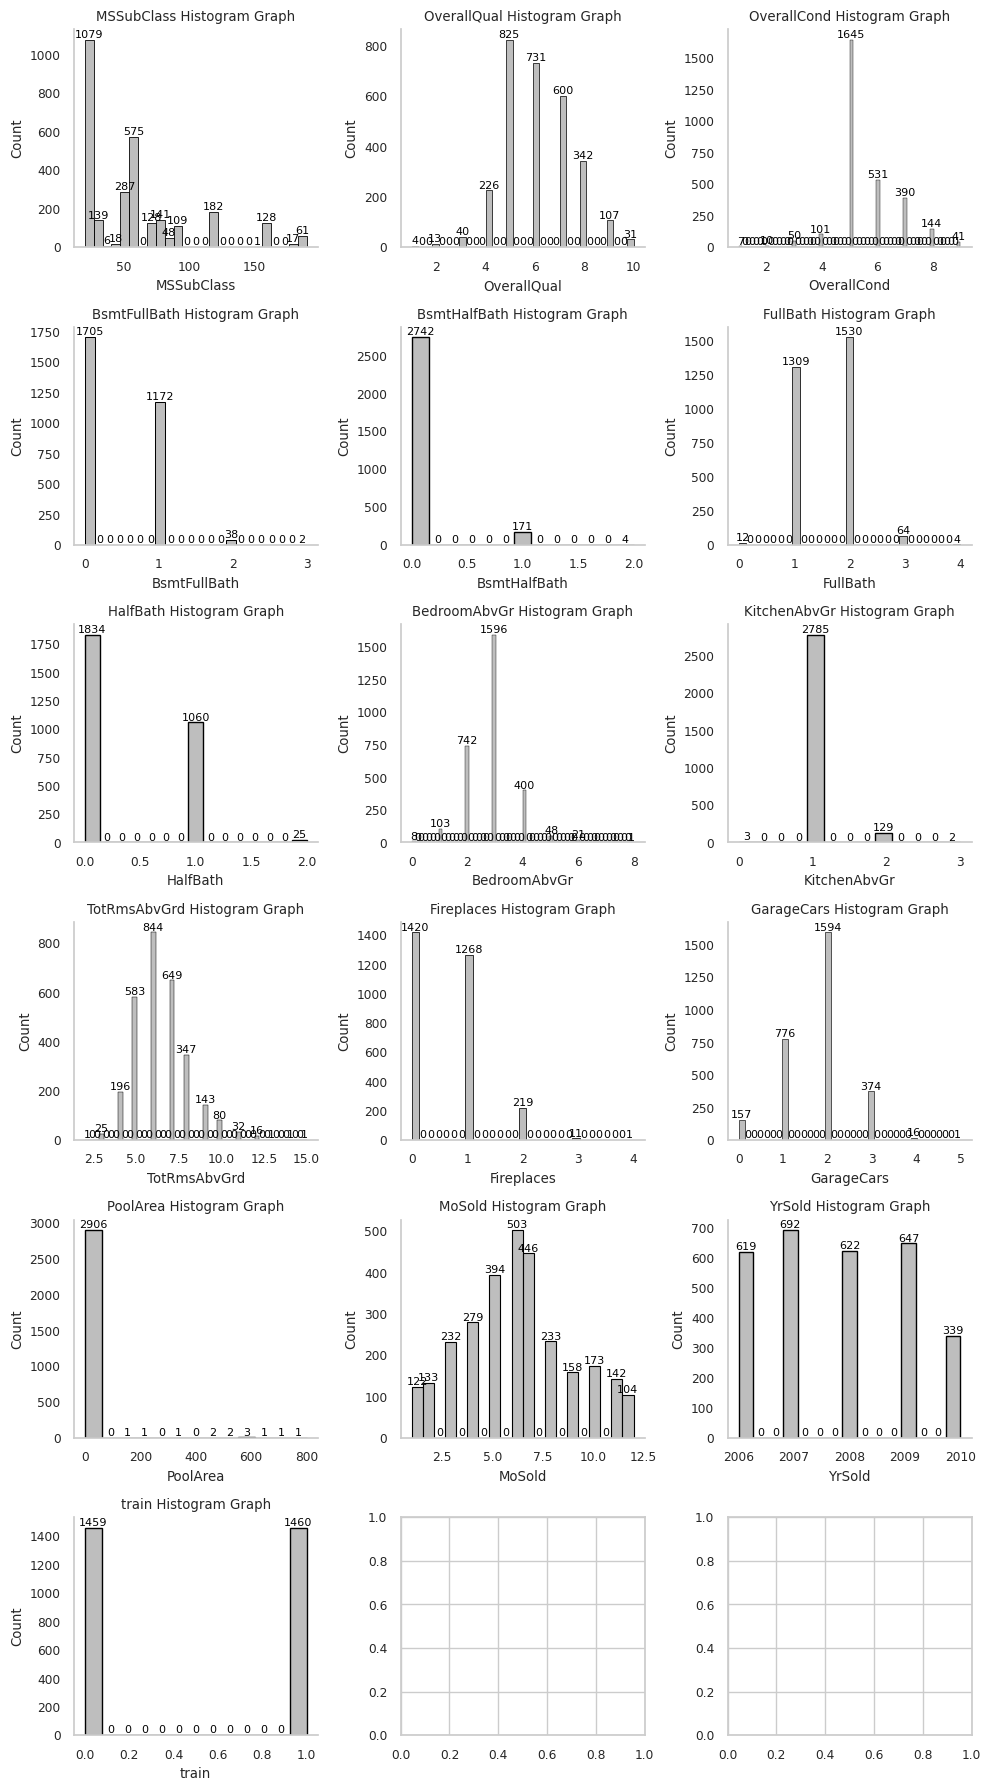

In [161]:
#check these variable are categorical or not
#ploting graphs for all these variables

#number of features
num_subplots = len(cat_features)
num_cols =3
num_rows = math.ceil(num_subplots/num_cols)

fig,axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10,3*num_rows))
axes=axes.flatten()

for i,(feature,ax) in enumerate(zip(cat_features,axes)):
    sns.histplot(x=feature, data = source,ax=ax,color = 'darkgrey', edgecolor = 'black')
    ax.set_title(f'{feature} Histogram Graph')
    ax.grid(False)
    plt.tight_layout()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
            fontsize=8, color='black', ha='center', va='bottom')
    if i >= num_subplots:
        ax.axis('off')


plt.show()

In [162]:
#all the above variables are num features
#hence not converting

In [163]:
#check num_features or not
num_features = []
for features in source.columns:
    num = source[features].nunique()
    if num >19 :
        if source[features].dtypes == 'object':
            num_features.append(features) 
print(num_features)

['Neighborhood']


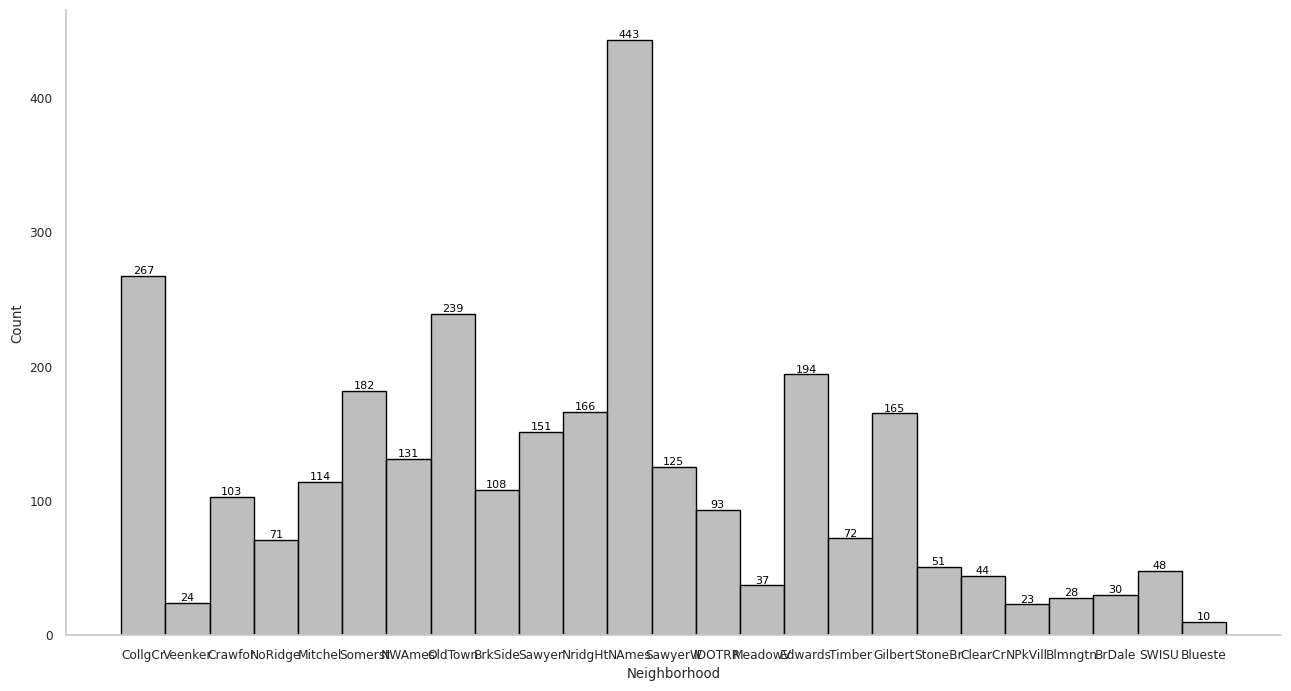

In [164]:
fig = plt.figure(figsize =(13, 7))
ax= sns.histplot(x='Neighborhood', data = source,color = 'darkgrey', edgecolor = 'black')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
            fontsize=8, color='black', ha='center', va='bottom')
plt.tight_layout()
plt.show()

Neighborhood is categorical variable, we will leave as it is. 

We will now fill null values

In [165]:
NULL_COUNT = source.isna().sum().sort_values(ascending = False)[:19]
NULL_COUNT

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageYrBlt      159
GarageQual       159
GarageFinish     159
GarageCond       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
dtype: int64

In [166]:
#segregating Null values columns based on categorical/Numerical varibales
Null_features_c=[]
for i in source.columns:
    if source[i].dtypes == 'object':
        if source[i].isna().sum() != 0:
            Null_features_c.append(i)
Null_features_c

['MSZoning',
 'Alley',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType']

In [167]:
#fill all categorical null values as None
for col in Null_features_c:
    source[col] = source[col].fillna('None')

In [168]:
#displaying numerical null values
NULL_COUNT = source.isna().sum().sort_values(ascending = False)[:10]
NULL_COUNT

SalePrice       1459
LotFrontage      486
GarageYrBlt      159
MasVnrArea        23
BsmtFullBath       2
BsmtHalfBath       2
GarageCars         1
GarageArea         1
TotalBsmtSF        1
BsmtUnfSF          1
dtype: int64

In [169]:
#Lot frontage will similar in same neighborhood
source['LotFrontage'] = source.groupby('Neighborhood')['LotFrontage'].transform(lambda x : x.fillna(x.median()))

In [170]:
#filling all rest Numerical null values with '0'
Null_features_n=[]
for i in source.columns:
    if source[i].dtypes != 'object':
        if source[i].isna().sum() != 0:
            Null_features_n.append(i)
for col in Null_features_n:
    source[col] = source[col].fillna(0)

Data is cleaned

Let's do data analysis

In [171]:
source['TotalBsmtBath'] = source['BsmtFullBath'] + source['BsmtFullBath']*0.5
source['TotalBath'] = source['FullBath'] + source['HalfBath']*0.5 
source['TotalSA']=source['TotalBsmtSF'] + source['1stFlrSF'] + source['2ndFlrSF']

In [172]:
bin_map  = {'TA':2,'Gd':3, 'Fa':1,'Ex':4,'Po':1,'None':0,'Y':1,'N':0,'Reg':3,'IR1':2,'IR2':1,'IR3':0,"None" : 0,
            "No" : 2, "Mn" : 2, "Av": 3,"Gd" : 4,"Unf" : 1, "LwQ": 2, "Rec" : 3,"BLQ" : 4, "ALQ" : 5, "GLQ" : 6
            }
source['ExterQual'] = source['ExterQual'].map(bin_map)
source['ExterCond'] = source['ExterCond'].map(bin_map)
source['BsmtCond'] = source['BsmtCond'].map(bin_map)
source['BsmtQual'] = source['BsmtQual'].map(bin_map)
source['HeatingQC'] = source['HeatingQC'].map(bin_map)
source['KitchenQual'] = source['KitchenQual'].map(bin_map)
source['FireplaceQu'] = source['FireplaceQu'].map(bin_map)
source['GarageQual'] = source['GarageQual'].map(bin_map)
source['GarageCond'] = source['GarageCond'].map(bin_map)
source['CentralAir'] = source['CentralAir'].map(bin_map)
source['LotShape'] = source['LotShape'].map(bin_map)
source['BsmtExposure'] = source['BsmtExposure'].map(bin_map)
source['BsmtFinType1'] = source['BsmtFinType1'].map(bin_map)
source['BsmtFinType2'] = source['BsmtFinType2'].map(bin_map)

PavedDrive =   {"N" : 0, "P" : 1, "Y" : 2}
source['PavedDrive'] = source['PavedDrive'].map(PavedDrive)

In [173]:
source = source.drop(['Id',],axis=1)

df_train = source[source['train'] == 1]


**3.DATA ANALYSIS**

let's start with SalePrice Analysis

<Axes: xlabel='SalePrice', ylabel='Count'>

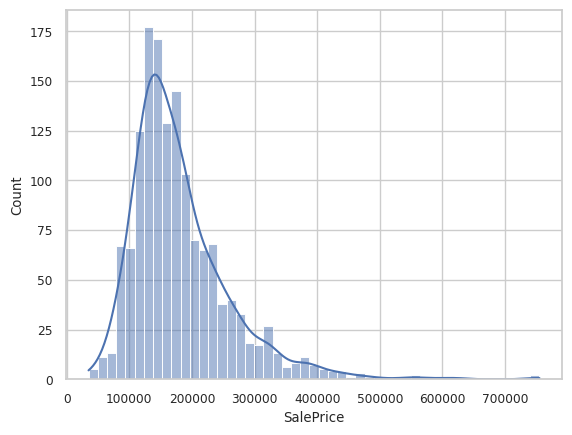

In [174]:
sns.histplot(df_train.SalePrice, kde = True)

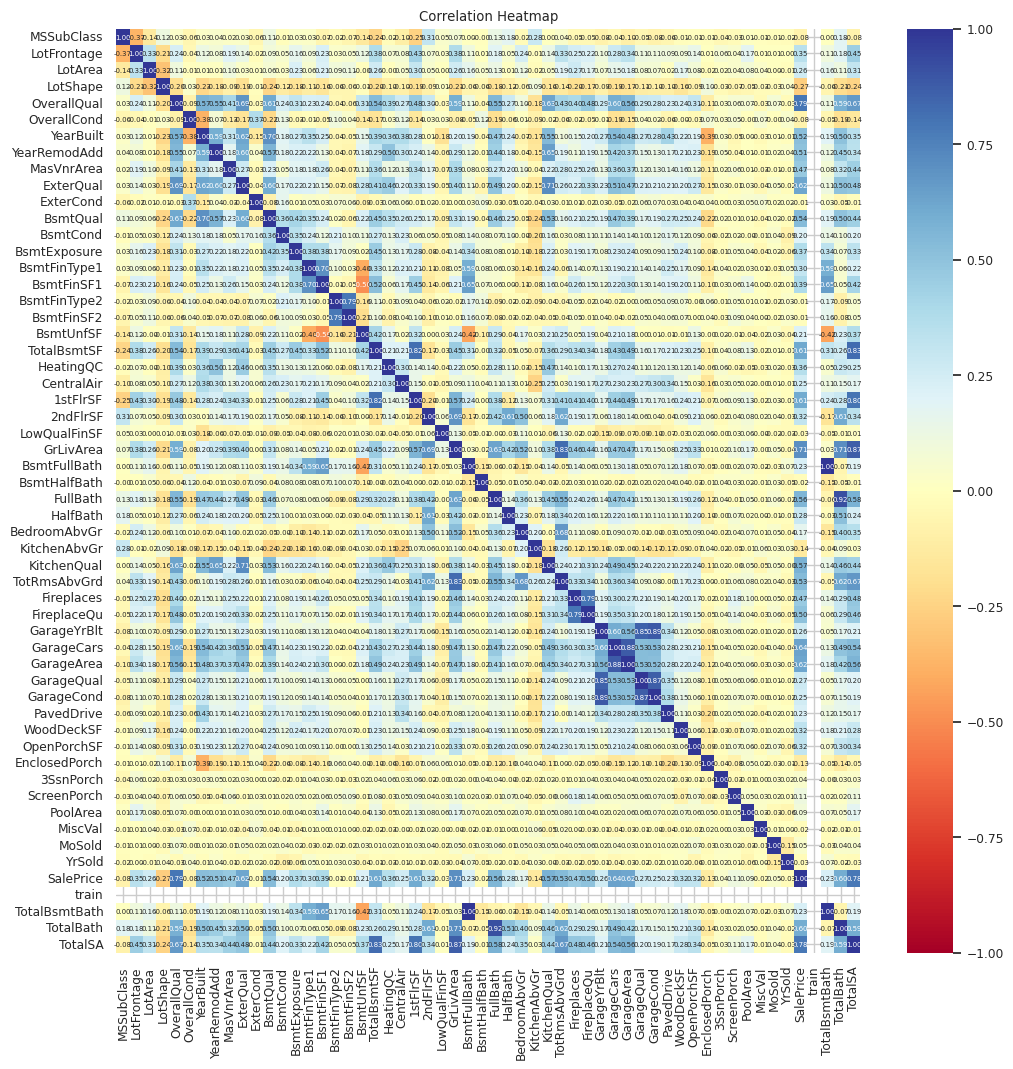

In [175]:
#let's check  correlation between all variables
corr_matrix = df_train.corr()


plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix,annot= True,cmap='RdYlBu',fmt=".2f",vmin=-1,vmax=1,annot_kws={"size":5})
plt.title("Correlation Heatmap")
plt.show()

Shows there is multi-colinearity within the variables.

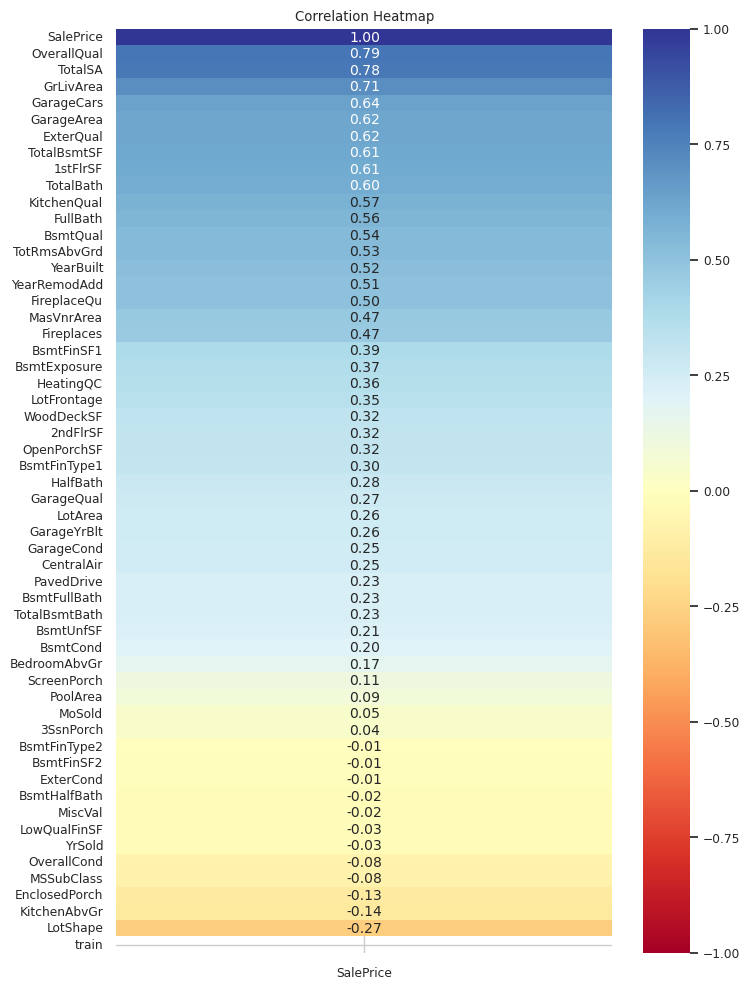

In [176]:
#let's check  correlation between all variables
corr_matrix = df_train.corr()[['SalePrice']]
corr_matrix_sorted = corr_matrix.sort_values(by ='SalePrice',ascending=False)


plt.figure(figsize=(8,12))
sns.heatmap(corr_matrix_sorted,annot= True,cmap='RdYlBu',fmt=".2f",vmin=-1,vmax=1,annot_kws={"size":10})
plt.title("Correlation Heatmap")
plt.show()

**4.DATA PREPROCESSING**

In [177]:
#Select categorical features
object_columns = source.select_dtypes(include=['object'])
#Using One hot encoder
source = pd.get_dummies(source, columns=object_columns.columns)

In [178]:
df_train = source[source['train'] == 1]
df_train = df_train.drop(['train'],axis=1)


df_test = source[source['train'] == 0]
df_test = df_test.drop(['SalePrice'],axis=1)
df_test = df_test.drop(['train'],axis=1)

**5:MODELING**

In [179]:
target= df_train['SalePrice']
df_train = df_train.drop(['SalePrice'],axis=1)

In [180]:
x_train,x_test,y_train,y_test = train_test_split(df_train,target,test_size=0.33,random_state=0)

In [181]:
xgb =XGBRegressor( booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1.5, n_estimators=2400,
             n_jobs=1, nthread=None, objective='reg:linear',
             reg_alpha=0.6, reg_lambda=0.6, scale_pos_weight=1, 
             silent=None, subsample=0.8, verbosity=1)

In [182]:
lgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=12000, 
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.4, 
                                       )

In [183]:
#Fitting
xgb.fit(x_train, y_train)
lgbm.fit(x_train, y_train,eval_metric='rmse')

[10:59:29] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              feature_fraction=0.4, learning_rate=0.01, max_bin=200,
              n_estimators=12000, num_leaves=4, objective='regression')

In [184]:
predict1 = xgb.predict(x_test)
predict = lgbm.predict(x_test)

In [185]:
print('Root Mean Square Error test = ' + str(math.sqrt(metrics.mean_squared_error(y_test, predict1))))
print('Root Mean Square Error test = ' + str(math.sqrt(metrics.mean_squared_error(y_test, predict))))

Root Mean Square Error test = 26450.24061899499
Root Mean Square Error test = 26966.825683760457


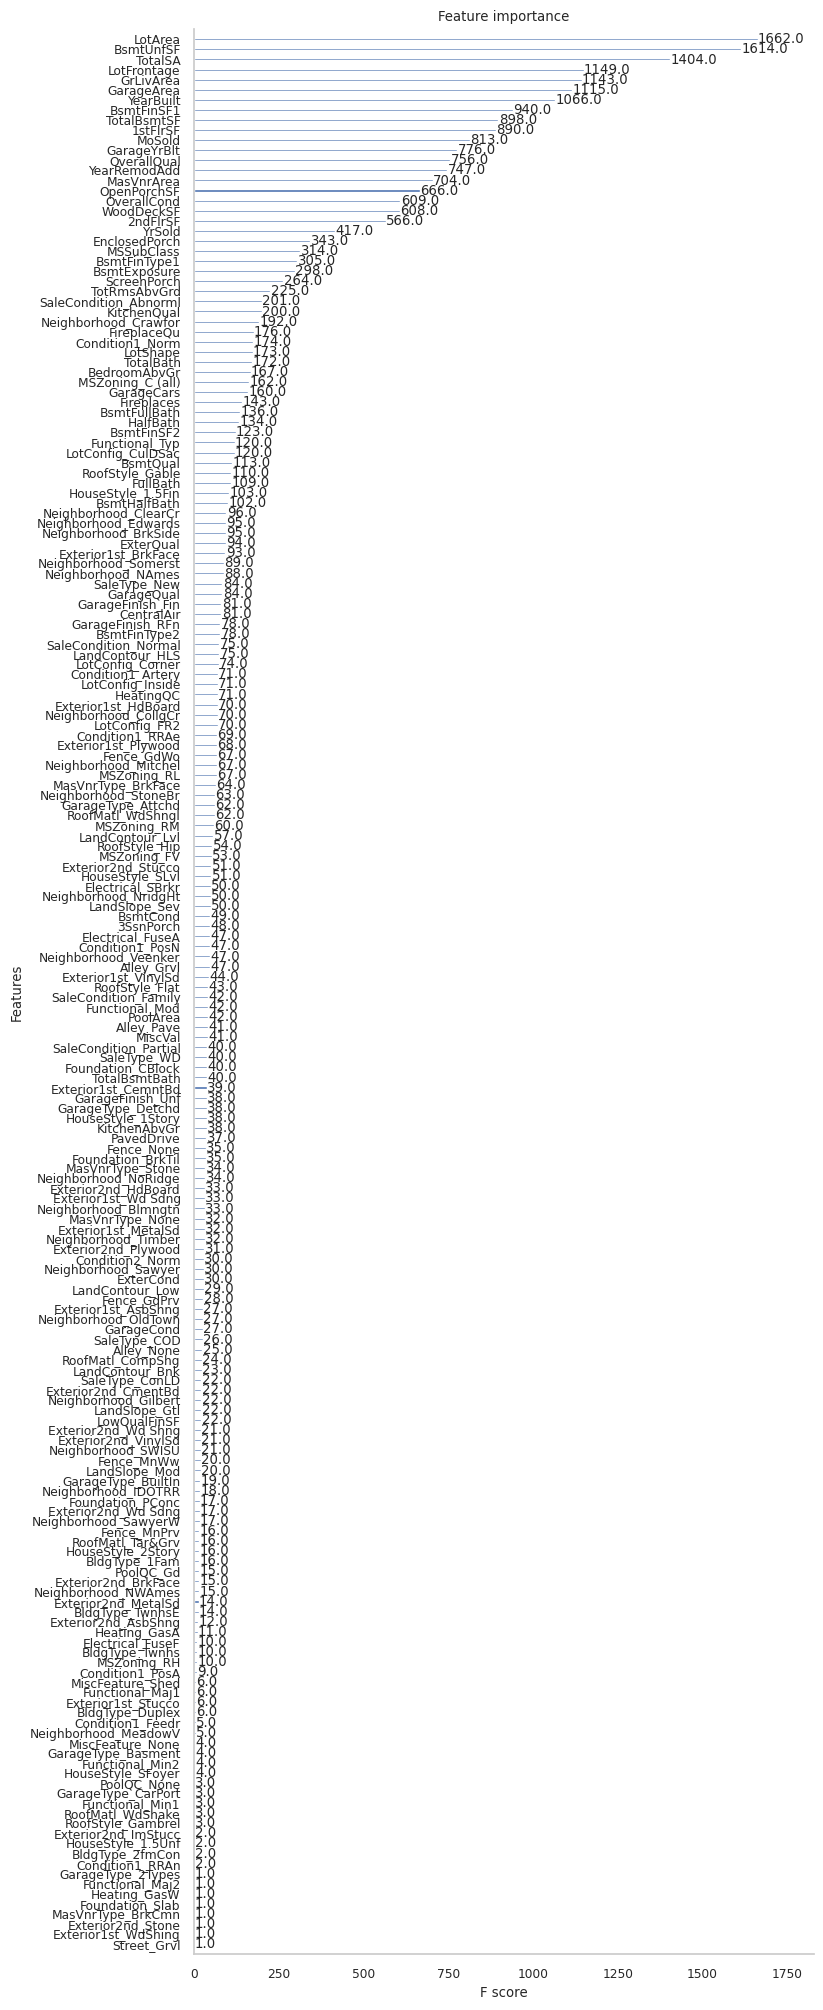

In [186]:
fig,ax = plt.subplots(figsize=(8,25))
xgb_f.plot_importance(xgb,ax=ax,importance_type='weight')
ax.grid(False)
plt.tick_params(axis='y',which='both',left=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [187]:
coef1 = Series(features,features_importances).sort_values()

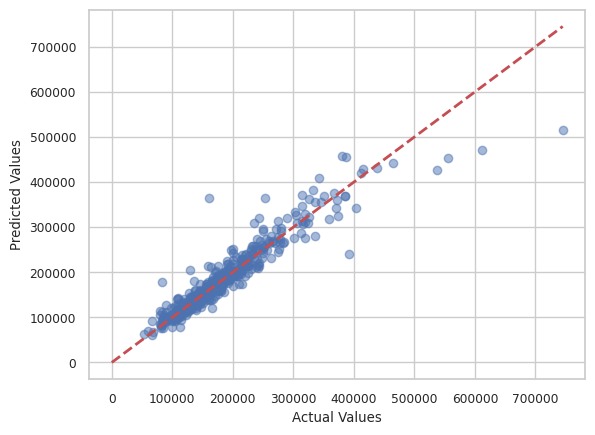

In [188]:
plt.scatter(y_test,predict1,alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
max_value = max(np.max(y_test),np.max(predict1))
plt.plot([0,max_value],[0,max_value],'r--',lw=2)

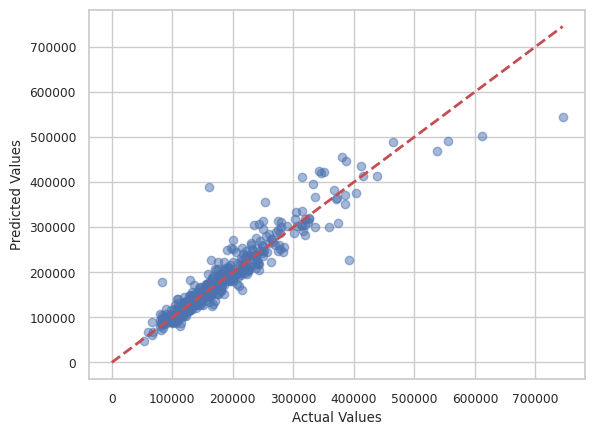

In [189]:
plt.scatter(y_test,predict,alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
max_value = max(np.max(y_test),np.max(predict))
plt.plot([0,max_value],[0,max_value],'r--',lw=2)